<img src="https://199lj33nqk3p88xz03dvn481-wpengine.netdna-ssl.com/wp-content/uploads/2021/08/CodeupFullColorLogo.png" />

---

# <center> Looking at Codeup Logs </center>

---

## Questions to Explore:

#### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
#### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
#### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
#### 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
#### 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
#### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
#### 7. Which lessons are least accessed? 
#### 8. Are there any additional insights?

---

## Imports: 

In [1]:
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standard imports
import numpy as np
import pandas as pd

from datetime import datetime

from env import user, password, host
from wrangle import get_db_url, ds_pop, most_pop, prep_cohort
from sklearn import metrics

---

## Acquire the Data:

In [2]:
# Activity among students and staff
df = pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None,
                  names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])
df

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [3]:
# Further Cohort Information
df2 = pd.read_sql('''select * from cohorts''', get_db_url(user, host, password, 'curriculum_logs'))
print(f'Length: {len(df2)}')
df2.head()

Length: 53


,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1


## Exploration:

In [4]:
# Look at our information
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    900223 non-null  object 
 1   time    900223 non-null  object 
 2   page    900222 non-null  object 
 3   id      900223 non-null  int64  
 4   cohort  847330 non-null  float64
 5   ip      900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [5]:
# Looking where null values lie
print(len(df[df.cohort.isnull()]))
df[df.cohort.isnull()].head()

52893


,date,time,page,id,cohort,ip
411,2018-01-26,16:46:16,/,48,NaN,97.105.19.61
412,2018-01-26,16:46:24,spring/extra-features/form-validation,48,NaN,97.105.19.61
425,2018-01-26,17:54:24,/,48,NaN,97.105.19.61
435,2018-01-26,18:32:03,/,48,NaN,97.105.19.61
436,2018-01-26,18:32:17,mysql/relationships/joins,48,NaN,97.105.19.61


#### These won't be dropped as they won't affect the exploration needed to be done on individual cohorts

In [6]:
df.groupby('ip').count().sort_values('date', ascending=False).head(10)

,date,time,page,id,cohort
ip,,,,,
97.105.19.58,284579,284579,284579,284579,268648
97.105.19.61,61662,61662,61662,61662,60530
192.171.117.210,9515,9515,9515,9515,9124
71.150.217.33,6791,6791,6791,6791,6791
76.185.145.231,4754,4754,4754,4754,4754
12.106.208.194,4360,4360,4360,4360,4343
67.11.50.23,4181,4181,4181,4181,4181
70.112.179.142,4117,4117,4117,4117,4117
70.121.183.95,3843,3843,3843,3843,3843


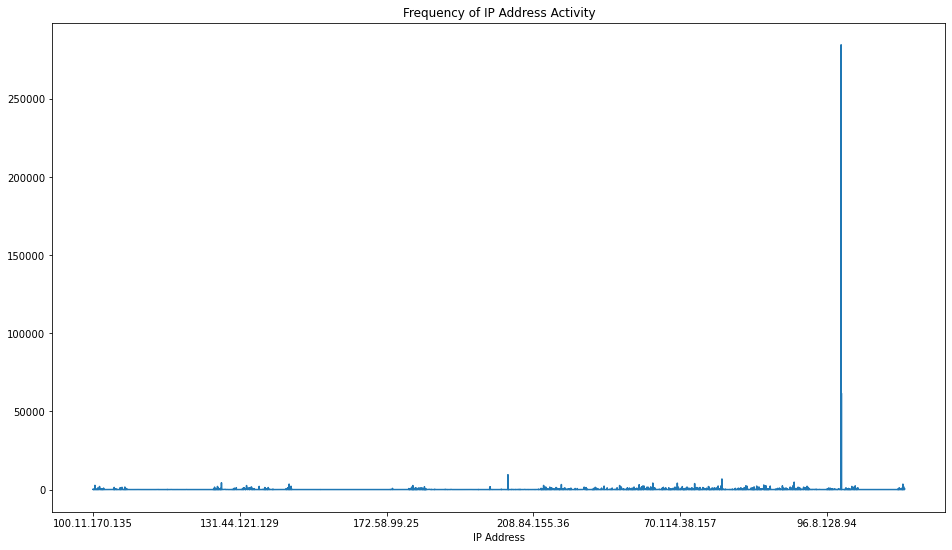

In [7]:
plt.figure(figsize=(16,9))
df.groupby('ip').count().date.plot()
plt.xlabel('Count')
plt.xlabel('IP Address')
plt.title('Frequency of IP Address Activity')
plt.show()

#### A few address are clearly more active than others

---

## Combine both Dataframes

In [8]:
df2 = prep_cohort(df2)

In [9]:
merge = pd.merge(df,df2, how='right')
# Program 1 and 4 no longer exists and is a small portion of the data
merge = merge[(merge.program_id != 1)&(merge.program_id != 4)]
merge

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
24364,2018-01-30,17:40:15,/,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24365,2018-01-30,17:40:21,spring,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24366,2018-01-30,17:40:24,spring/fundamentals/controllers,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24367,2018-01-30,17:40:54,spring/fundamentals/views,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24368,2018-01-30,17:41:02,spring/fundamentals/controllers,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
...,...,...,...,...,...,...,...,...,...,...
847331,2021-04-21,12:13:18,javascript-i/testing-user-functions,969.0,139.0,107.77.169.64,Oberon,2021-04-12,2021-10-01,2
847332,2021-04-21,12:31:48,javascript-i,969.0,139.0,107.77.169.64,Oberon,2021-04-12,2021-10-01,2
847333,2021-04-21,12:31:58,javascript-i/javascript-with-html,969.0,139.0,107.77.169.64,Oberon,2021-04-12,2021-10-01,2
847334,2021-04-21,12:32:01,javascript-i/testing-user-functions,969.0,139.0,107.77.169.64,Oberon,2021-04-12,2021-10-01,2


### 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [10]:
# Program and top 10 visited subjects
most_pop(merge)

Program: 2
                          program_id
page                                
/                              35814
javascript-i                   17457
toc                            17428
search/search_index.json       15212
java-iii                       12683
html-css                       12569
java-ii                        11719
spring                         11376
jquery                         10693
mysql                          10318
---
Program: 3
                                          program_id
page                                                
/                                               8358
search/search_index.json                        2203
classification/overview                         1785
1-fundamentals/modern-data-scientist.jpg        1655
1-fundamentals/AI-ML-DL-timeline.jpg            1651
1-fundamentals/1.1-intro-to-data-science        1633
classification/scale_features_or_not.svg        1590
fundamentals/AI-ML-DL-timeline.jpg              1443


#### Web Development review more often Java, Javascript, Spring, and HTML-CSS while Data Science students tend to look at Data Science Fundamentals alot

---

### 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [11]:
for coh in merge[merge.program_id == 3].cohort.value_counts().index.sort_values():
    print(f'{coh}')
    print(merge[merge.cohort == coh][['cohort','page']].groupby('page').count().sort_values('cohort', ascending=False).head())
    print('---')

30.0
Empty DataFrame
Columns: [cohort]
Index: []
---
34.0
                                          cohort
page                                            
/                                           1967
1-fundamentals/modern-data-scientist.jpg     650
1-fundamentals/AI-ML-DL-timeline.jpg         648
1-fundamentals/1.1-intro-to-data-science     640
search/search_index.json                     588
---
55.0
                                          cohort
page                                            
/                                           1712
6-regression/1-overview                      595
search/search_index.json                     538
1-fundamentals/modern-data-scientist.jpg     467
1-fundamentals/AI-ML-DL-timeline.jpg         465
---
59.0
                                          cohort
page                                            
/                                           2980
classification/overview                     1109
classification/scale_features_or_not.svg  

#### Curie's second most popular topic was regression, which is not seen with any other cohort

In [12]:
%%capture
for coh in merge.cohort.value_counts().index.sort_values():
    print(f'{coh}: Program {merge[merge.cohort == coh].program_id.mean()}')
    # Printing the 10 most visited pages by cohort
    print(merge[merge.cohort == coh][['cohort','page']].groupby('page').count().sort_values('cohort', ascending=False).head(4))
    print('---')

---

### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [13]:
for val in merge.id.value_counts().index.sort_values():
    if (len(merge[merge.id == val]) < 2):
        print(f'ID: {val}')
        print(len(merge[merge.id == val]))
        print('---')

ID: 165.0
1
---
ID: 592.0
1
---
ID: 619.0
1
---
ID: 652.0
1
---
ID: 879.0
1
---
ID: 918.0
1
---
ID: 940.0
1
---


In [14]:
merge[merge.id == 165]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
25316,2018-03-30,21:37:04,index.html,165.0,16.0,24.243.3.200,Niagara,2016-10-26,2017-03-09,2


In [15]:
merge[merge.id == 592]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
236419,2020-02-07,12:17:45,/,592.0,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2


In [16]:
merge[merge.id == 619]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
607862,2020-03-23,14:10:17,/,619.0,57.0,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2


In [17]:
merge[merge.id == 652]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
248306,2020-05-18,09:56:10,loguout,652.0,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2


In [18]:
merge[merge.id == 879]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
813453,2021-01-26,12:21:18,/,879.0,135.0,136.50.50.187,Marco,2021-01-25,2021-07-19,2


In [19]:
merge[merge.id == 918]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
838397,2021-03-15,16:59:56,/,918.0,138.0,71.221.46.112,Neptune,2021-03-15,2021-09-03,2


In [20]:
merge[merge.id == 940]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
838427,2021-03-15,17:00:37,/,940.0,138.0,70.121.129.79,Neptune,2021-03-15,2021-09-03,2


#### Student ID's 165, 592, 619, 652, 879, 918, 940 all come from the Web-Dev Program and only logged once on page "/", "logout, or "index.html

---

### 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

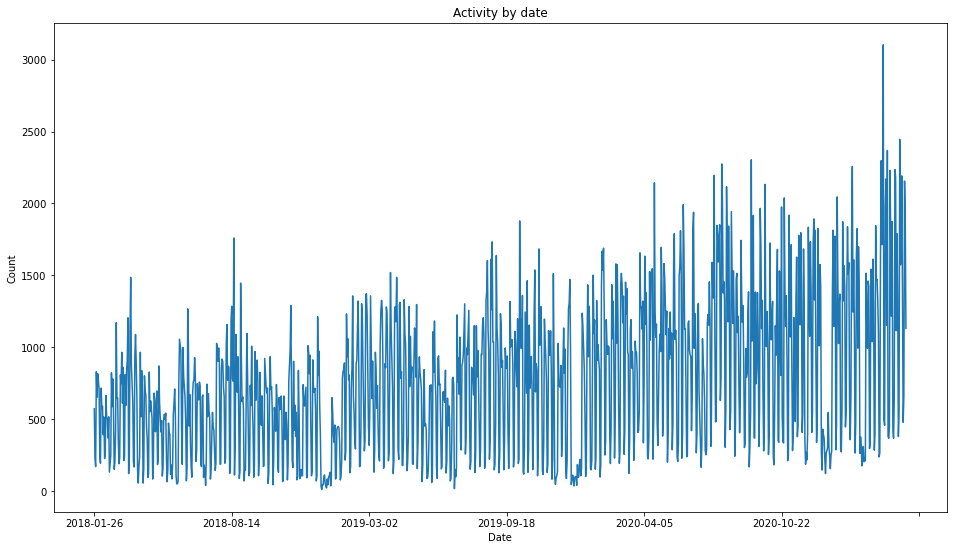

In [21]:
plt.figure(figsize=(16,9))
df.groupby('date').count().ip.plot()
plt.ylabel('Count')
plt.xlabel('Date')
plt.title('Activity by date')
plt.show()

#### It looks like activity dramatically dipped in early 2019 as well as 2020 and 2021

---

### 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [22]:
merge[merge.end_date < merge.date]

,date,time,page,id,cohort,ip,name,start_date,end_date,program_id
24364,2018-01-30,17:40:15,/,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24365,2018-01-30,17:40:21,spring,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24366,2018-01-30,17:40:24,spring/fundamentals/controllers,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24367,2018-01-30,17:40:54,spring/fundamentals/views,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
24368,2018-01-30,17:41:02,spring/fundamentals/controllers,72.0,15.0,108.248.9.192,Mammoth,2016-09-26,2017-02-02,2
...,...,...,...,...,...,...,...,...,...,...
758394,2021-04-20,20:39:56,spring/setup,773.0,62.0,70.121.201.159,Jupiter,2020-09-21,2021-03-30,2
758395,2021-04-21,09:42:38,/,756.0,62.0,108.95.37.118,Jupiter,2020-09-21,2021-03-30,2
758396,2021-04-21,09:42:40,search/search_index.json,756.0,62.0,108.95.37.118,Jupiter,2020-09-21,2021-03-30,2
758397,2021-04-21,09:42:44,javascript-ii/RESTful-api,756.0,62.0,108.95.37.118,Jupiter,2020-09-21,2021-03-30,2


In [23]:
for pro in merge[merge.end_date < merge.date].program_id.value_counts().index.sort_values():
    print(f'Program: {pro}')
    print(merge[merge.program_id == pro][['program_id','page']].groupby('page').count().sort_values('program_id', ascending=False).head(10))
    print('---')

Program: 2
                          program_id
page                                
/                              35814
javascript-i                   17457
toc                            17428
search/search_index.json       15212
java-iii                       12683
html-css                       12569
java-ii                        11719
spring                         11376
jquery                         10693
mysql                          10318
---
Program: 3
                                          program_id
page                                                
/                                               8358
search/search_index.json                        2203
classification/overview                         1785
1-fundamentals/modern-data-scientist.jpg        1655
1-fundamentals/AI-ML-DL-timeline.jpg            1651
1-fundamentals/1.1-intro-to-data-science        1633
classification/scale_features_or_not.svg        1590
fundamentals/AI-ML-DL-timeline.jpg              1443


#### Web Dev student continue to sharpen their skills in Javascript, Java iii, and HTML-CSS
#### DS Students review fundamentals and classification

---

### 7. Which lessons are least accessed? 

In [24]:
for pro in merge.program_id.value_counts().index.sort_values():
    print(f'Program: {pro}')
    # Least 5 most visited pages by program
    print(merge[merge.program_id == pro][['program_id','page']].groupby('page').count().sort_values('program_id', ascending=False).tail(5))
    print('---')

Program: 2
                                                    program_id
page                                                          
content/mysql/relationships/sub-queries.html                 1
content/mysql/sample-database/gitbook/images/fa...           1
content/php_iii/classes-and-objects-i/construct...           1
content/php_iv/classes-and-objects-ii/late-stat...           1
wp-login                                                     1
---
Program: 3
                                 program_id
page                                       
cli/4-navigating-the-filesystem           1
regression/project/null                   1
creating-charts                           1
curie-statistics-assessment               1
%20https://github.com/RaulCPena           1
---


#### Web Dev least viewed subjects are SQL and PHP, while DS students' are regression, charts and statistics

---

### Additional Info: 

In [25]:
for coh in merge.cohort.value_counts().index.sort_values():
    print(f'Cohort: {coh}')
    print(len(merge[merge.cohort ==coh]))
    print('---')

Cohort: 15.0
691
---
Cohort: 16.0
755
---
Cohort: 18.0
2158
---
Cohort: 20.0
1
---
Cohort: 21.0
7444
---
Cohort: 22.0
30926
---
Cohort: 23.0
28534
---
Cohort: 24.0
35636
---
Cohort: 25.0
25586
---
Cohort: 26.0
27749
---
Cohort: 27.0
20743
---
Cohort: 28.0
84031
---
Cohort: 29.0
38096
---
Cohort: 30.0
1
---
Cohort: 31.0
25359
---
Cohort: 32.0
29356
---
Cohort: 33.0
40730
---
Cohort: 34.0
26538
---
Cohort: 51.0
32888
---
Cohort: 52.0
28033
---
Cohort: 53.0
36902
---
Cohort: 55.0
21582
---
Cohort: 56.0
33568
---
Cohort: 57.0
33844
---
Cohort: 58.0
29855
---
Cohort: 59.0
32015
---
Cohort: 60.0
1
---
Cohort: 61.0
17713
---
Cohort: 62.0
37109
---
Cohort: 132.0
23691
---
Cohort: 133.0
14715
---
Cohort: 134.0
16623
---
Cohort: 135.0
16397
---
Cohort: 136.0
1
---
Cohort: 137.0
8562
---
Cohort: 138.0
7276
---
Cohort: 139.0
1672
---


#### There seems to be missing (or much less of) log data for Mammoth, Redwood, Niagara,  Ada, and Io cohorts